In [1]:
%matplotlib inline

import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [2]:
# https://stackoverflow.com/questions/26319259/sci-kit-and-regression-summary
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [3]:
df = pd.read_json('../data/twtc_13k.json', orient='split')

print(df.shape)
df.head()

(13616, 28)


,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,source,key_mlbam,uid,key_uuid,key_bbref,key_bbref_minors,mlb_played_first,birthdate,debut_age,key_fangraphs
0,Luis Perdomo,None,2015,RHP,2018,Not to be confused with the Luis Perdomo the C...,0,50,50,0,...,mlbam,606131,0_2015,69c08698-cd47-4e3e-b942-913a3c0b4bce,perdolu02,perdom002lui,2016.0,1993-05-09T00:00:00.000Z,22.6,14682
1,Bruce Maxwell,24,2015,C,2016,Maxwell led NCAA Division III with 15 homers ...,55,0,0,0,...,mlbam,622194,0_2015,1a8850d5-52a7-45ed-88ef-e9cfc7bdee6b,maxwebr01,maxwel001bru,2016.0,1990-12-20T00:00:00.000Z,25.0,13866
2,Sam Huff,20,2018,C,2021,Huff led Arizona high schoolers with 14 homers...,50,0,0,0,...,mlbam,669087,0_2018,cf05afc8-7884-4dd6-b1d5-fbca7ddce9bc,None,huff--000sam,NaN,1998-01-14T00:00:00.000Z,NaN,None
3,Anthony Banda,22.4,2016,LHP,2017,"In 2011, the D-backs drafted Banda in the 33rd...",0,45,50,55,...,mlbam,607455,0_2016,2e627856-cb46-4c36-ad1e-604f35414565,bandaan01,banda-000ant,2017.0,1993-08-10T00:00:00.000Z,23.4,14706
4,Mike Wright,23,2013,RHP,2014,The East Carolina product jumped on the fast t...,0,50,50,0,...,mlbam,605541,0_2013,75103df0-e411-4822-ba04-3edf4ee05a67,wrighmi01,wright000den,2015.0,1990-01-03T00:00:00.000Z,25.0,12586


In [4]:
ages = df[['age', 'year', 'eta']].copy().apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=0)
ages = ages.dropna()

ages['expected'] = ages['age'] + (ages['eta'] - ages['year'])

print(ages.shape)
ages.head()

(8874, 4)


,age,year,eta,expected
1,24.0,2015,2016.0,25.0
2,20.0,2018,2021.0,23.0
3,22.4,2016,2017.0,23.4
4,23.0,2013,2014.0,24.0
7,18.4,2015,2019.0,22.4


In [5]:
ages[['age', 'expected']].describe().round(3)

,age,expected
count,8874.000,8874.000
mean,21.668,23.652
std,2.151,1.354
min,15.800,19.000
25%,20.100,22.700
50%,21.800,23.700
75%,23.100,24.500
max,31.900,31.900


In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(ages['age'], ages['expected'], test_size=0.1, random_state=42)

clf = LinearRegression().fit(train_X.values.reshape(-1, 1), train_Y)
preds = clf.predict(test_X.values.reshape(-1, 1))

print(f'Expected = ({clf.coef_[0].round(3)} * Age) + {clf.intercept_.round(3)}')
regression_results(test_Y, preds)

Expected = (0.482 * Age) + 13.21
explained_variance:  0.5807
r2:  0.5802
MAE:  0.6924
MSE:  0.759
RMSE:  0.8712


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


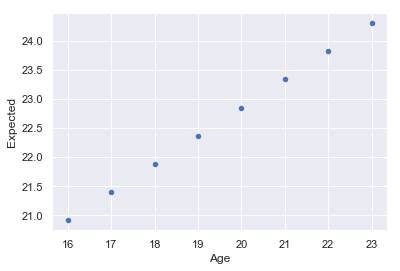

In [7]:
age = range(16, 24)
expected = clf.predict(np.array(age).reshape(-1, 1))

pd.DataFrame(list(zip(age, expected)), columns=['Age', 'Expected']).plot.scatter('Age', 'Expected')

## Labeling successes and busts

In [8]:
mask = ~df.debut_age.isnull()

df['expected'] = -1
df.loc[mask, 'expected'] = clf.predict(df.loc[mask, 'debut_age'].values.reshape(-1, 1)).round(3)

df['label'] = (df['debut_age'].fillna(0) < df['expected']).astype('int')

df.to_json('labelled_data.json', orient='split')
df.head()

,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,uid,key_uuid,key_bbref,key_bbref_minors,mlb_played_first,birthdate,debut_age,key_fangraphs,expected,label
0,Luis Perdomo,None,2015,RHP,2018,Not to be confused with the Luis Perdomo the C...,0,50,50,0,...,0_2015,69c08698-cd47-4e3e-b942-913a3c0b4bce,perdolu02,perdom002lui,2016.0,1993-05-09T00:00:00.000Z,22.6,14682,24.104,1
1,Bruce Maxwell,24,2015,C,2016,Maxwell led NCAA Division III with 15 homers ...,55,0,0,0,...,0_2015,1a8850d5-52a7-45ed-88ef-e9cfc7bdee6b,maxwebr01,maxwel001bru,2016.0,1990-12-20T00:00:00.000Z,25.0,13866,25.261,1
2,Sam Huff,20,2018,C,2021,Huff led Arizona high schoolers with 14 homers...,50,0,0,0,...,0_2018,cf05afc8-7884-4dd6-b1d5-fbca7ddce9bc,None,huff--000sam,NaN,1998-01-14T00:00:00.000Z,NaN,None,-1.000,0
3,Anthony Banda,22.4,2016,LHP,2017,"In 2011, the D-backs drafted Banda in the 33rd...",0,45,50,55,...,0_2016,2e627856-cb46-4c36-ad1e-604f35414565,bandaan01,banda-000ant,2017.0,1993-08-10T00:00:00.000Z,23.4,14706,24.490,1
4,Mike Wright,23,2013,RHP,2014,The East Carolina product jumped on the fast t...,0,50,50,0,...,0_2013,75103df0-e411-4822-ba04-3edf4ee05a67,wrighmi01,wright000den,2015.0,1990-01-03T00:00:00.000Z,25.0,12586,25.261,1


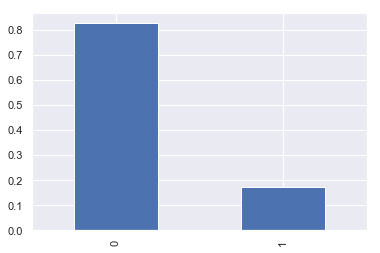

In [9]:
(df.label.value_counts() / len(df)).plot.bar()

In [10]:
df[(df.label == 0) & (df.eta.replace('', 0).astype(int, errors='ignore') >= 2019)]

,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,uid,key_uuid,key_bbref,key_bbref_minors,mlb_played_first,birthdate,debut_age,key_fangraphs,expected,label
2,Sam Huff,20,2018,C,2021,Huff led Arizona high schoolers with 14 homers...,50,0,0,0,...,0_2018,cf05afc8-7884-4dd6-b1d5-fbca7ddce9bc,None,huff--000sam,NaN,1998-01-14T00:00:00.000Z,NaN,None,-1.00,0
6,Jefrey Ramos,None,2019,OF,2022,The Braves went all-in during the 2016-17 inte...,40,0,0,0,...,0_2019,4c2df4cb-8629-40b3-9623-55515be07028,None,ramos-002jef,NaN,1999-02-10T00:00:00.000Z,NaN,None,-1.00,0
9,Travis Blankenhorn,22.4,2019,2B,2020,Blankenhorn was an outstanding athlete in high...,50,0,0,0,...,0_2019,d7a1e5d6-392d-4697-99b6-bd135028ac7f,None,blanke002tra,NaN,1996-08-03T00:00:00.000Z,NaN,None,-1.00,0
13,Daz Cameron,20,2017,OF,2019,"As a high school sophomore, Cameron emerged as...",50,0,0,0,...,0_2017,de4d33e2-7d08-4909-a8e4-172308a6cd51,None,camero000daz,NaN,1997-01-15T00:00:00.000Z,NaN,None,-1.00,0
15,Grant Little,20.5,2018,OF,2021,Left-hander Steven Gingery and right-hander Da...,45,0,0,0,...,0_2018,1bb71897-8f04-459f-aeac-84e2c304dffd,None,little000gra,NaN,1997-07-08T00:00:00.000Z,NaN,None,-1.00,0
20,Oscar Tovar,None,2017,RHP,2020,An international signee in 2014 out of Venezue...,0,45,45,0,...,0_2017,781e1b5e-9d3b-45f9-abc5-f3cd52d0832f,None,tovar-000osc,NaN,1998-03-19T00:00:00.000Z,NaN,None,-1.00,0
22,Jose Sanchez,None,2017,SS,2021,The Nationals blew well past their allotted bo...,50,0,0,0,...,0_2017,06316ece-a828-4152-bfdb-0f23c2aa354b,None,sanche034jos,NaN,2000-07-12T00:00:00.000Z,NaN,None,-1.00,0
23,Cornelius Randolph,17.6,2015,OF,2019,Griffin (Ga.) High School in Georgia last had...,55,0,0,0,...,0_2015,a3016614-b484-4b98-ab3d-5634e8b4f0cc,None,randol000cor,NaN,1997-06-02T00:00:00.000Z,NaN,None,-1.00,0
26,Mason Englert,18.2,2018,RHP,2022,Though he wasn't considered the best pitching ...,0,50,50,50,...,0_2018,baf49334-5b60-4b07-b6f9-a56a073bb649,None,engler000mas,NaN,1999-11-01T00:00:00.000Z,NaN,None,-1.00,0
32,Gage Hinsz,18.7,2015,RHP,2019,High school pitchers from places like Montana ...,0,45,45,45,...,0_2015,0307a5d7-f9a3-43f1-8967-77e6ec8278ba,None,hinsz-000gag,NaN,1996-04-20T00:00:00.000Z,NaN,None,-1.00,0
